In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


2023-10-02 19:12:07.702504: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load the preprocessed DataFrame
df = pd.read_csv('../data/preprocessed_df16000.csv')

In [4]:
# Remove rows with NaN values in the text column
df = df.dropna(how='any', subset=['text'])

# Print the DataFrame
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 15912 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15912 non-null  object
 1   target  15912 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 372.9+ KB


In [5]:
tweet_df = df.copy()

In [6]:
!pip install transformers

     |████████████████████████████████| 7.6 MB 11.7 MB/s eta 0:00:01
  Using cached filelock-3.12.4-py3-none-any.whl (11 kB)
     |████████████████████████████████| 295 kB 11.9 MB/s eta 0:00:01
  Using cached tokenizers-0.13.3-cp310-cp310-macosx_10_11_x86_64.whl (4.0 MB)
  Using cached safetensors-0.3.3-cp310-cp310-macosx_12_0_x86_64.whl (403 kB)
     |████████████████████████████████| 173 kB 20.4 MB/s eta 0:00:01
You should consider upgrading via the '/Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/.venv2/bin/python3 -m pip install --upgrade pip' command.


In [7]:
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification


/Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/.venv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [21]:
num_classes=len(tweet_df.target.unique())
num_classes

2

In [22]:
# Create the BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
max_length = 150  # Adjust as needed
input_ids = []
attention_masks = []

for tweet in tweet_df['text']:
    encoded_dict = tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        return_attention_mask=True
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(tweet_df['target'])

In [32]:
len(input_ids),len(attention_masks),len(tweet_df['target'])


(15912, 15912, 15912)

In [33]:
from sklearn.model_selection import train_test_split

train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,tweet_df['target'],attention_masks,test_size=0.2)


In [39]:
print(f'Train inp shape {(train_inp.shape)}, Test inp shape {(val_inp.shape)}')
print(f'Train label shape {(train_label.shape)}, Test label shape {(val_label.shape)}')
print(f'Train attention mask shape {(train_mask.shape)}, Test attention mask shape {(val_mask.shape)}')

Train inp shape (12729, 150), Test inp shape (3183, 150)
Train label shape (12729,), Test label shape (3183,)
Train attention mask shape (12729, 150), Test attention mask shape (3183, 150)


In [40]:
model.summary()


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
import mlflow

# Check if the experiment exists, and if not, create it
experiment_name = "bert_model"
if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(experiment_name)

mlflow.set_experiment(experiment_name)

/Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/.venv2/lib/python3.10/site-packages/pydantic/_internal/_fields.py:128: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/.venv2/lib/python3.10/site-packages/pydantic/_internal/_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


<Experiment: artifact_location='file:///Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/notebooks/mlruns/997808080936251577', creation_time=1696266891770, experiment_id='997808080936251577', last_update_time=1696266891770, lifecycle_stage='active', name='bert_model', tags={}>

In [17]:
mlflow.start_run(description="bert_model")

<ActiveRun: >

In [ ]:
import tensorflow as tf

optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


batch_size=64

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-5, patience=5)]
history = model.fit([train_inp,train_mask],train_label,batch_size=batch_size, epochs=2, validation_data=([val_inp,val_mask],val_label), callbacks=callbacks)

Epoch 1/2
200/200 [==============================] - ETA: 0s - loss: 0.5473 - accuracy: 0.7195

200/200 [==============================] - 450s 2s/step - loss: 0.5473 - accuracy: 0.7195 - val_loss: 0.4982 - val_accuracy: 0.7638 - lr: 3.0000e-05
Epoch 2/2
200/200 [==============================] - ETA: 0s - loss: 0.4135 - accuracy: 0.8154

200/200 [==============================] - 392s 2s/step - loss: 0.4135 - accuracy: 0.8154 - val_loss: 0.5044 - val_accuracy: 0.7691 - lr: 3.0000e-05


In [ ]:
model.save_weights(f'./sample_data/model_weights.h5')


In [ ]:

# Evaluate the model on the test set
loss, accuracy = model.evaluate([val_inp,val_mask],val_label)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f"Loss: {loss * 100:.2f}%")

# scores = model.evaluate(test_data, batch_size=batch_size)
# print("ACCURACY:",scores[1])
# print("LOSS:",scores[0])


100/100 [==============================] - 41s 357ms/step - loss: 0.5044 - accuracy: 0.7691
Accuracy: 76.91%
Loss: 50.44%


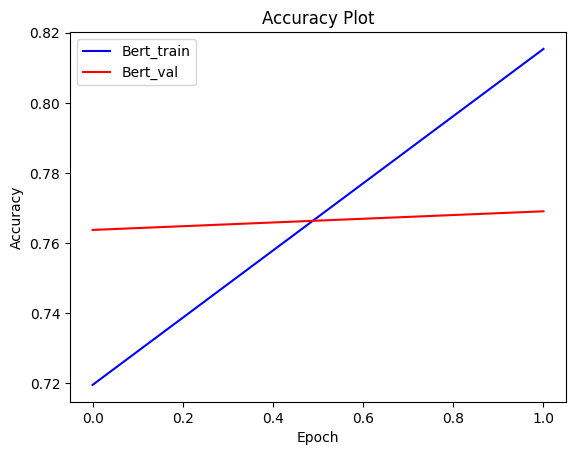

In [ ]:
plt.plot(history.history['accuracy'], c= 'b')
plt.plot(history.history['val_accuracy'], c='r')
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Bert_train', 'Bert_val'], loc='upper left')
plt.savefig('accuracy_plot.png')

plt.show()


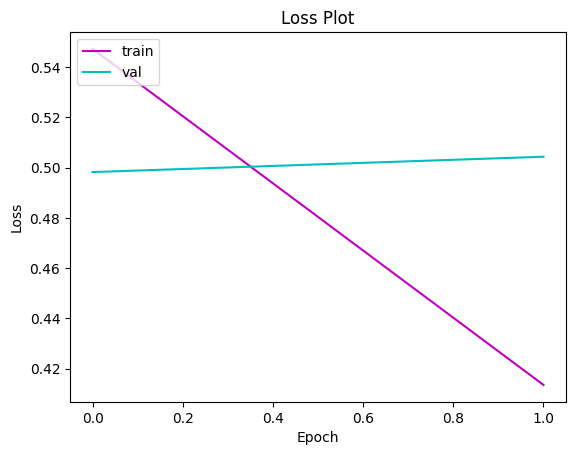

In [ ]:

plt.plot(history.history['loss'], c='m')
plt.plot(history.history['val_loss'], c='c')
plt.title('Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.savefig('loss_plot.png')
plt.show()


In [ ]:
# Track your experiment with MLflow
mlflow.log_metrics({'accuracy': accuracy})
mlflow.log_metrics({'loss': loss})

In [29]:
# Log hyperparameters
mlflow.log_params({'pretrained_model_name_or_path': 'bert-base-uncased', 'num_labels': 2})
mlflow.log_params({'epochs': 2, 'batch_size': 32})


In [31]:
import joblib

# Save the model to a file
joblib.dump(model, 'bert_model.pkl')
mlflow.log_artifact('bert_model.pkl')

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [32]:
mlflow.end_run()

In [2]:
!mlflow ui

[2023-09-22 03:06:39 +0200] [23271] [INFO] Starting gunicorn 20.1.0
[2023-09-22 03:06:39 +0200] [23271] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-09-22 03:06:39 +0200] [23271] [ERROR] Retrying in 1 second.
[2023-09-22 03:06:40 +0200] [23271] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-09-22 03:06:40 +0200] [23271] [ERROR] Retrying in 1 second.
[2023-09-22 03:06:41 +0200] [23271] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-09-22 03:06:41 +0200] [23271] [ERROR] Retrying in 1 second.
[2023-09-22 03:06:42 +0200] [23271] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-09-22 03:06:42 +0200] [23271] [ERROR] Retrying in 1 second.
[2023-09-22 03:06:43 +0200] [23271] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-09-22 03:06:43 +0200] [23271] [ERROR] Retrying in 1 second.
[2023-09-22 03:06:44 +0200] [23271] [ERROR] Can't connect to ('127.0.0.1', 5000)
Running the mlflow server failed. Please see the logs above for details.
